In [1]:
!qbraid jobs enable amazon_braket

You have already enabled qBraid Quantum Jobs in the amazon_braket environment.


In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
from pprint import pprint as pp
import networkx as nx

from braket.aws import AwsDevice
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.devices import LocalSimulator

from quera_ahs_utils.plotting import show_global_drive, show_register
from quera_ahs_utils.drive import get_drive 

from iquhack_utils import find_UDG_radius, visualize_graph, get_blockade_radius, C6, save_result_json, open_json

from utils import postprocess_MIS, analysis_MIS

In [2]:
plt.rcParams['figure.dpi'] = 140

In [3]:
qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
capabilities = qpu.properties.paradigm
pp(capabilities.dict())

C6 = float(capabilities.rydberg.dict()['c6Coefficient']) # rad m^6/sec

{'braketSchemaHeader': {'name': 'braket.device_schema.quera.quera_ahs_paradigm_properties',
                        'version': '1'},
 'lattice': {'area': {'height': Decimal('0.000076'),
                      'width': Decimal('0.000075')},
             'geometry': {'numberSitesMax': 256,
                          'positionResolution': Decimal('1E-7'),
                          'spacingRadialMin': Decimal('0.000004'),
                          'spacingVerticalMin': Decimal('0.000004')}},
 'performance': {'lattice': {'positionErrorAbs': Decimal('1E-7')},
                 'rydberg': {'rydbergGlobal': {'rabiFrequencyErrorRel': Decimal('0.02')}}},
 'qubitCount': 256,
 'rydberg': {'c6Coefficient': Decimal('5.42E-24'),
             'rydbergGlobal': {'detuningRange': (Decimal('-125000000.0'),
                                                 Decimal('125000000.0')),
                               'detuningResolution': Decimal('0.2'),
                               'detuningSlewRateMax': Decimal(

In [4]:
def square_lattice(num_rows, num_cols):
    points = []
    
    num_centers = num_rows * num_cols
    num_corners = (num_rows + 1) * (num_cols + 1)
    graph_connections = []
    
    # Build corners
    for row in range(num_rows + 1):
        for col in range(num_cols + 1):
            start = np.array([col, row])
            points.append(start)
            
    # Build centers
    curr_id = num_corners
    for row in range(num_rows):
        for col in range(num_cols):
            start = np.array([col, row])
            points.append(start + np.array([1/2, 1/2])) # centers
            bottomleft_corner_id = row * (num_cols + 1) + col
            bottomright_corner_id = bottomleft_corner_id + 1
            topleft_corner_id = bottomleft_corner_id + num_cols + 1
            topright_corner_id = topleft_corner_id + 1
            graph_connections.append((topleft_corner_id, curr_id))
            graph_connections.append((topright_corner_id, curr_id))
            graph_connections.append((bottomleft_corner_id, curr_id))
            graph_connections.append((bottomright_corner_id, curr_id))
            curr_id = curr_id + 1
            # points.append(start + np.array([0, 1]))
    # points.append(np.array([num_cells, 0]))
    # points.append(np.array([num_cells, 1]))
    
    centers = range(num_centers)
    corners = range(num_centers, num_centers + num_corners)
    
    graph = nx.Graph(graph_connections)
    
    return np.array(points), graph

In [5]:
def linear_chain(n_verts, direction):
    points = []
    for i in range(n_verts):
        if direction == 'HORIZ':
            points.append(np.array([i, 0]))
        if direction == 'VERT':
            points.append(np.array([0, i]))
        if direction == 'DIAG':
            points.append(np.array([i, i]) / np.sqrt(2)) 
            
    graph = nx.Graph([(i, i+1) for i in range(n_verts - 1)])
    return np.array(points), graph

Points: [[0.  0. ]
 [1.  0. ]
 [2.  0. ]
 [3.  0. ]
 [4.  0. ]
 [5.  0. ]
 [6.  0. ]
 [0.  1. ]
 [1.  1. ]
 [2.  1. ]
 [3.  1. ]
 [4.  1. ]
 [5.  1. ]
 [6.  1. ]
 [0.  2. ]
 [1.  2. ]
 [2.  2. ]
 [3.  2. ]
 [4.  2. ]
 [5.  2. ]
 [6.  2. ]
 [0.  3. ]
 [1.  3. ]
 [2.  3. ]
 [3.  3. ]
 [4.  3. ]
 [5.  3. ]
 [6.  3. ]
 [0.  4. ]
 [1.  4. ]
 [2.  4. ]
 [3.  4. ]
 [4.  4. ]
 [5.  4. ]
 [6.  4. ]
 [0.  5. ]
 [1.  5. ]
 [2.  5. ]
 [3.  5. ]
 [4.  5. ]
 [5.  5. ]
 [6.  5. ]
 [0.  6. ]
 [1.  6. ]
 [2.  6. ]
 [3.  6. ]
 [4.  6. ]
 [5.  6. ]
 [6.  6. ]
 [0.5 0.5]
 [1.5 0.5]
 [2.5 0.5]
 [3.5 0.5]
 [4.5 0.5]
 [5.5 0.5]
 [0.5 1.5]
 [1.5 1.5]
 [2.5 1.5]
 [3.5 1.5]
 [4.5 1.5]
 [5.5 1.5]
 [0.5 2.5]
 [1.5 2.5]
 [2.5 2.5]
 [3.5 2.5]
 [4.5 2.5]
 [5.5 2.5]
 [0.5 3.5]
 [1.5 3.5]
 [2.5 3.5]
 [3.5 3.5]
 [4.5 3.5]
 [5.5 3.5]
 [0.5 4.5]
 [1.5 4.5]
 [2.5 4.5]
 [3.5 4.5]
 [4.5 4.5]
 [5.5 4.5]
 [0.5 5.5]
 [1.5 5.5]
 [2.5 5.5]
 [3.5 5.5]
 [4.5 5.5]
 [5.5 5.5]]
# Points: 85


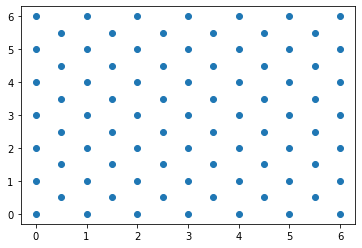

Edges: [(7, 49), (7, 55), (49, 8), (49, 0), (49, 1), (8, 50), (8, 55), (8, 56), (1, 50), (50, 9), (50, 2), (9, 51), (9, 56), (9, 57), (2, 51), (51, 10), (51, 3), (10, 52), (10, 57), (10, 58), (3, 52), (52, 11), (52, 4), (11, 53), (11, 58), (11, 59), (4, 53), (53, 12), (53, 5), (12, 54), (12, 59), (12, 60), (5, 54), (54, 13), (54, 6), (13, 60), (14, 55), (14, 61), (55, 15), (15, 56), (15, 61), (15, 62), (56, 16), (16, 57), (16, 62), (16, 63), (57, 17), (17, 58), (17, 63), (17, 64), (58, 18), (18, 59), (18, 64), (18, 65), (59, 19), (19, 60), (19, 65), (19, 66), (60, 20), (20, 66), (21, 61), (21, 67), (61, 22), (22, 62), (22, 67), (22, 68), (62, 23), (23, 63), (23, 68), (23, 69), (63, 24), (24, 64), (24, 69), (24, 70), (64, 25), (25, 65), (25, 70), (25, 71), (65, 26), (26, 66), (26, 71), (26, 72), (66, 27), (27, 72), (28, 67), (28, 73), (67, 29), (29, 68), (29, 73), (29, 74), (68, 30), (30, 69), (30, 74), (30, 75), (69, 31), (31, 70), (31, 75), (31, 76), (70, 32), (32, 71), (32, 76), (32,

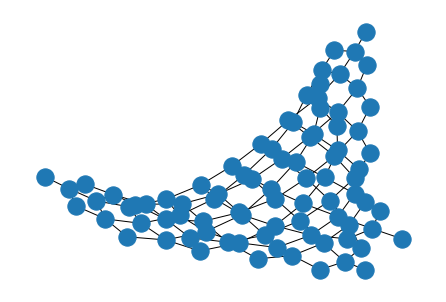

In [6]:
# points, graph = linear_chain(18, 'DIAG')
points, graph = square_lattice(6, 6)

print(f"Points: {points}")
print(f"# Points: {len(points)}")
plt.scatter(*zip(*(points)))
plt.show()

print(f"Edges: {graph.edges}")
nx.draw(graph)

Unit Disk Radius: 0.8408964152537146
Minimum Radius: 0.7071067811865476
Maximum Radius: 1.0


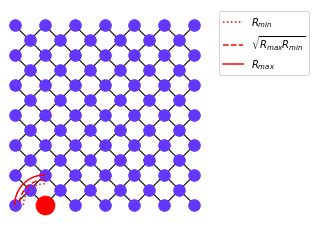

In [7]:
unitdisk_radius, min_radius, max_radius = find_UDG_radius(points, graph)
print(f"Unit Disk Radius: {unitdisk_radius}\nMinimum Radius: {min_radius}\nMaximum Radius: {max_radius}")

figure = plt.figure()
axes = plt.subplot(1,1,1)
visualize_graph(axes, graph, points)

x0, y0 = (1,0)
angles = np.linspace(np.pi/2,np.pi,1001)

axes.plot(min_radius*np.cos(angles)+x0,min_radius*np.sin(angles)+y0,
        linestyle=":",color="red",label="$R_{min}$")
axes.plot(unitdisk_radius*np.cos(angles)+x0,unitdisk_radius*np.sin(angles)+y0,
        linestyle="--",color="red",label="$\sqrt{R_{max}R_{min}}$")
axes.plot(max_radius*np.cos(angles)+x0,max_radius*np.sin(angles)+y0,
        linestyle="-",color="red",label="$R_{max}$")

axes.scatter(x0,y0,color="red",zorder=3,marker="o",s=350)
axes.set_xlim((-0.25,10))

plt.legend(loc="upper right",)
plt.show()

Blockade Radius: 8.044e-06m
Unit Disk Radius: 0.841


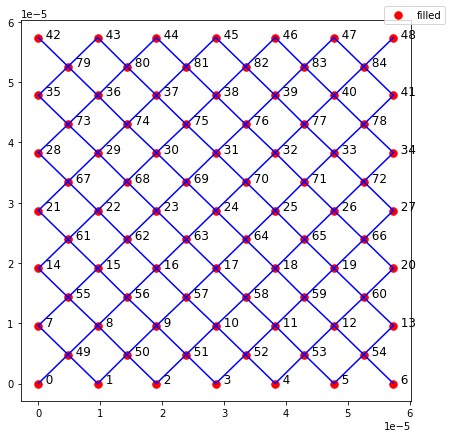

In [8]:
detuning_final = 20e6 # rad/sec

# Find blockade radius
blockade_radius = get_blockade_radius(detuning_final, 0) # no rabi amplitude at the end
print('Blockade Radius: {:0.3e}m'.format(blockade_radius))
print('Unit Disk Radius: {:0.3f}'.format(unitdisk_radius))

# Compute scaling value a, which converts between logical and physical coordinates
a = blockade_radius / unitdisk_radius

# Generate the atom register
register = AtomArrangement()
for x in points:
    register.add((a * x).round(7))

# print(register)
show_register(register, blockade_radius = blockade_radius)

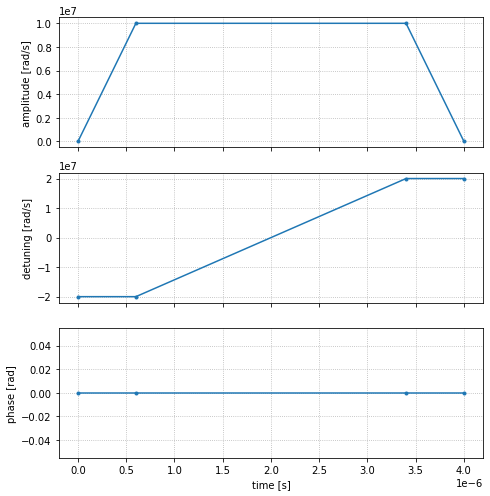

In [9]:
# Define a set of time points
time_points = [0, 0.6e-6, 3.4e-6, 4e-6]

# Define the strength of the transverse field Ω
amplitude_min = 0
amplitude_max = 10e6  # rad / sec

# Define the strength of the detuning Δ
detuning_initial = -20e6     # rad / sec
detuning_final = detuning_final # Defined above

amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]  # piecewise linear
detuning_values = [detuning_initial, detuning_initial, detuning_final, detuning_final]  # piecewise linear
phase_values = [0, 0, 0, 0]  # piecewise constant

# Define the drive
drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)
show_global_drive(drive);

In [10]:
ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)

In [15]:
if points.size > 12:
    raise BaseException(f"Are you sure you want to simulate a {len(points)}-vert graph?")
device = LocalSimulator("braket_ahs")
ahs_run = device.run(ahs_program, shots=1)

result  = ahs_run.result()
save_result_json("square_lattice_mis.json", result)

BaseException: Are you sure you want to simulate a 85-vert graph?

In [126]:
raise BaseException("Only run this cell when you are ready to submit your job.")
#DO NOT RUN THIS UNLESS YOU ARE SURE
nshots = 100
task = qpu.run(ahs_program, shots=nshots)
print(task)


BaseException: Only run this cell when you are ready to submit your job.

In [125]:

# save_result_json("4x4_square_graph_mis.json",task44.result())
# save_result_json("1x1_square_graph_mis.json",task11.result())
# save_result_json("2x2_square_graph_mis.json",task22.result())
# save_result_json("6x6_square_graph_mis.json",task66.result())

In [ ]:
task

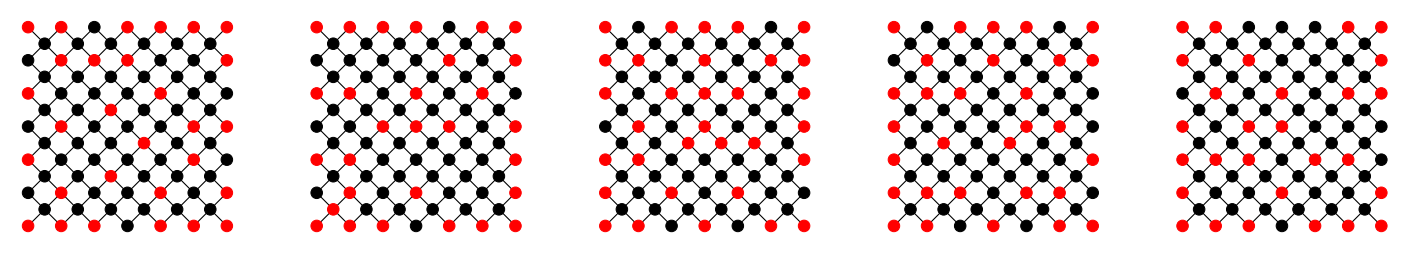

In [11]:
filename = "6x6_square_graph_mis.json"
result_json = open_json(filename)
num_measurements = len(result_json["measurements"])    
sequences = [result_json["measurements"][i]["post_sequence"] for i in range(num_measurements)]

figure = plt.figure(figsize=(25,15))

start = 10
num_shown = 5
for i in range(num_shown):
    axes = plt.subplot(1,num_shown,i+1)
    
    color_lookup = {0:"r",1:'k'}
    sequence_colors = [color_lookup[sequences[i+start][j]] for j in range(len(sequences[i]))]
    visualize_graph(axes, graph, points, node_colors = sequence_colors)
    
plt.show()

In [18]:
points[48]

array([6., 6.])

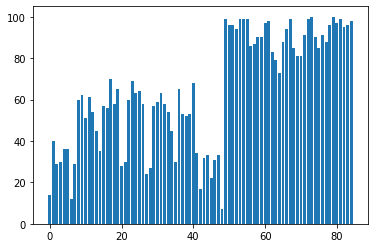

In [12]:
# result_json["measurements"][5]
post_bitstrings = np.array([q["post_sequence"] for q in result_json["measurements"]])
post_bitstrings.shape
n_occur_ground = np.sum(post_bitstrings, axis=0)
n_occur_ground.shape
# unique_n_occur, count = np.unique(n_occur_ground, return_counts = True)

# unique_n_occur
plt.bar(list(range(0, n_occur_ground.size)), n_occur_ground)
plt.show()

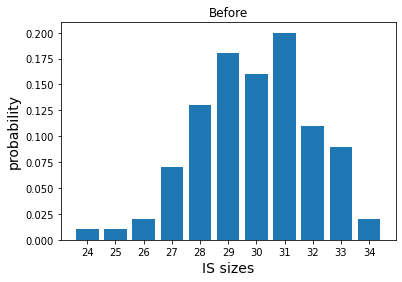

In [13]:
post_bitstrings = np.array([q["post_sequence"] for q in result_json["measurements"]])
IS_sizes = np.sum(1-post_bitstrings,axis=1)
unique_IS_sizes, counts = np.unique(IS_sizes, return_counts=True)

plt.bar(unique_IS_sizes, counts/counts.sum())
plt.title("Before")
plt.xticks(unique_IS_sizes)
plt.xlabel("IS sizes",fontsize=14)
plt.ylabel("probability",fontsize=14)
plt.show()

Average pre-processed size:  29.9300
Average post-processed IS size: 28.8200
FIXED


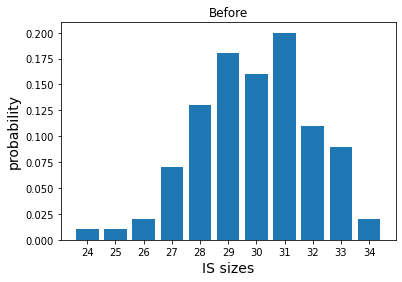

None

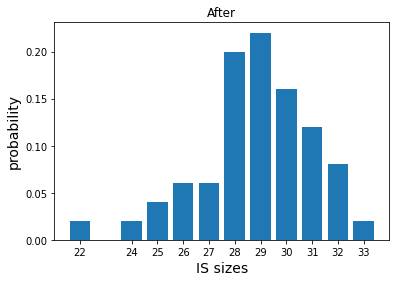

None

[ 0  1  3  4  6  7  9 10 13 14 18 19 21 25 27 28 29 30 31 33 35 38 39 41
 42 43 44 45 46 47 48 62 63]
['r', 'r', 'k', 'r', 'r', 'k', 'r', 'r', 'k', 'r', 'r', 'k', 'k', 'r', 'r', 'k', 'k', 'k', 'r', 'r', 'k', 'r', 'k', 'k', 'k', 'r', 'k', 'r', 'r', 'r', 'r', 'r', 'k', 'r', 'k', 'r', 'k', 'k', 'r', 'r', 'k', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'r', 'r', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k']


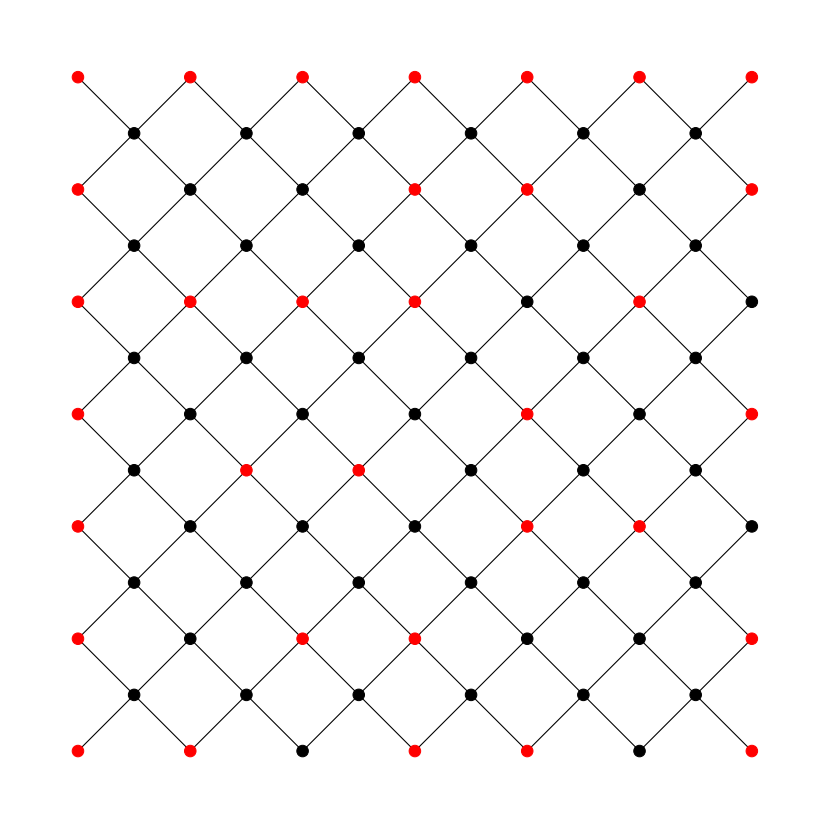

In [14]:
result_json = open_json(filename)
IS_sizes,pp_bitstrings = analysis_MIS(graph, result_json)

ind, = np.where(IS_sizes==IS_sizes.max())
# ind = list(range(1,n_show+1))
n_show = min(len(ind),5)

figure = plt.figure(figsize=(25,15))
for i in range(n_show):
    axes = plt.subplot(1,n_show,i+1)

    color_lookup = {0:"r",1:'k'}
    seqs_color = [color_lookup[pp_bitstrings[ind[i]][j]] for j in range(len(pp_bitstrings[ind[i]]))]
    visualize_graph(axes, graph, {a: points[a] for a in range(len(points))}, node_colors = seqs_color)
    
    # nx.draw_networkx_nodes(graph, points, nodelist = list(range(len(points))),node_size=1225/np.sqrt(len(graph.nodes)),ax=axes,node_color=seqs_color)
    # print(points)
    print(np.where(pp_bitstrings[ind[i]]==0)[0])
    print(seqs_color)
    
plt.show()

[0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20, 23, 24, 25, 26, 28, 31, 34, 36, 38, 41, 42, 44, 46, 47, 48, 77]


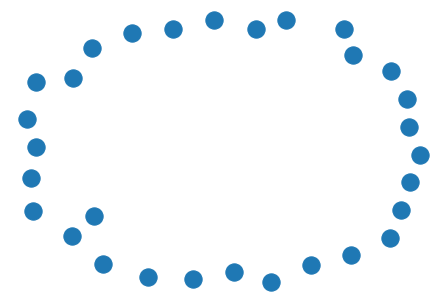

In [48]:
pp = pp_bitstrings[0]
print(list(nx.subgraph(graph, np.nonzero(pp==0)[0]).nodes))
nx.draw(nx.subgraph(graph, np.nonzero(pp==0)[0]))

In [15]:
IS_sizes

array([1., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 4., 4.